# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
from PIL import Image
import cv2 as cv
from tqdm import tqdm


from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

np.random.seed(42)
np.random.RandomState(42)


RandomState(MT19937) at 0x1EB21A7AF40

In [2]:
def summary(data) : 
    """ Take a pandas dataframe and create a summary about missing values """
    result = (pd.DataFrame(data.dtypes, columns=["Data Type"]).reset_index().rename(columns={'index': 'Column'}))
    result["Unique"] = data.nunique().values
    result["Null"] = data.isna().sum().values
    result["%null"] = np.round(data.isna().sum().values / data.shape[0] * 100, decimals=2)
    return result


In [ ]:
data = pd.read_csv('data/ddi_metadata.csv')

data.head()


In [ ]:
data.drop(['Unnamed: 0'], axis=1, inplace = True)
data.head()


In [5]:
summary(data)


,Column,Data Type,Unique,Null,%null
0,DDI_ID,int64,656,0,0.0
1,DDI_file,object,656,0,0.0
2,skin_tone,int64,3,0,0.0
3,malignant,bool,2,0,0.0
4,disease,object,78,0,0.0


## Now we'll try to get a new column: Melanoma and Non-Melanoma Cancers or Neither (Benign)


In [6]:
indexes = data.index
melanoma_column = []

for index in indexes:
    if data.loc[index, "malignant"]:
        melanoma_column.append(data.loc[index, "disease"])
    else:
        melanoma_column.append("Benign")


data["melanoma_col"] = melanoma_column




In [ ]:
indexes = data.index
melanoma_column = []

for index in indexes:
    if data.loc[index, "malignant"]:
        melanoma_column.append(data.loc[index, "disease"])
    else:
        melanoma_column.append("Benign")


data["melanoma_col"] = melanoma_column

cancer_types = data.loc[data["melanoma_col"] != "Benign", "melanoma_col"].unique()

melanoma_list = [
    'melanoma', 'melanoma-in-situ', 'melanoma-acral-lentiginous', 
    'nodular-melanoma-(nm)']
cancer_types = [c for c in cancer_types if pd.notna(c)] 
non_melanoma_list = [c for c in cancer_types if c not in melanoma_list]

data["Disease_Group"] = "False"
data.loc[data["melanoma_col"].isin(melanoma_list), "Disease_Group"] = "melanoma"
data.loc[data["melanoma_col"].isin(non_melanoma_list), "Disease_Group"] = "Non_melanoma"
data.loc[data["melanoma_col"] == "Benign", "Disease_Group" ] = "Non_melanoma"
data["Disease_Group"].value_counts()


In [8]:
data.drop(['melanoma_col', 'disease'], axis=1, inplace = True)


## Create a new column which will contain the path of the images

In [9]:
image_directory = 'data'

data['DDI_path'] = data['DDI_file'].apply(lambda file_name: os.path.join(image_directory, file_name))
data.head()


,DDI_ID,DDI_file,skin_tone,malignant,Disease_Group,DDI_path
0,1,000001.png,56,True,melanoma,data\000001.png
1,2,000002.png,56,True,melanoma,data\000002.png
2,3,000003.png,56,True,Non_melanoma,data\000003.png
3,4,000004.png,56,True,Non_melanoma,data\000004.png
4,5,000005.png,12,True,Non_melanoma,data\000005.png


# Get the number of channel in each image

In [10]:
indexes = data.index
channel_nbr = []

for index in indexes:
    image = cv.imread(data.DDI_path[index])
    
    if image is not None:
        channel_nbr.append(image.shape[2])
    else:
        print(f"Warning: Could not read image at {data.DDI_path[index]}")
        channel_nbr.append(None)


np.unique(channel_nbr)


array([3])

In [11]:
def get_channel_count(image_path):
    image = cv.imread(image_path)
    if image is not None:
        return image.shape[2]  
    else:
        print(f"Warning: Could not read image at {image_path}")
        return None

data['channel_nbr'] = data['DDI_path'].apply(get_channel_count)

unique_channel_nbr = data['channel_nbr'].unique()

print(f"The unique shapes present in our dataset are: {unique_channel_nbr}")


The unique shapes present in our dataset are: [3]


**So all our images are in the RGB format**

In [12]:
data.drop(["channel_nbr"], axis=1, inplace=True)
data.head()


,DDI_ID,DDI_file,skin_tone,malignant,Disease_Group,DDI_path
0,1,000001.png,56,True,melanoma,data\000001.png
1,2,000002.png,56,True,melanoma,data\000002.png
2,3,000003.png,56,True,Non_melanoma,data\000003.png
3,4,000004.png,56,True,Non_melanoma,data\000004.png
4,5,000005.png,12,True,Non_melanoma,data\000005.png


# EDA

Now we'll try to get some idea about the data

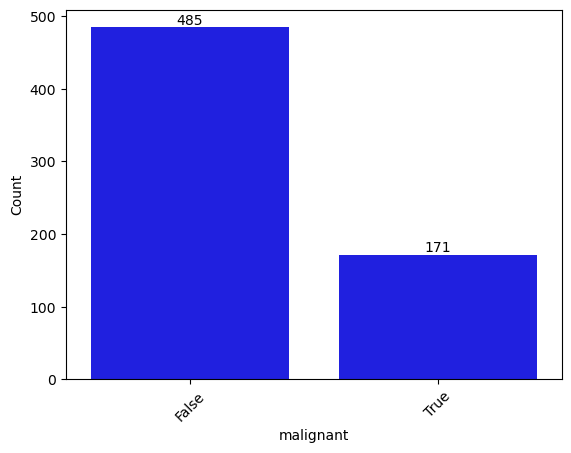

In [13]:
my_plot = sns.countplot(x='malignant', data=data, color='b')

for p in my_plot.patches:
    count = int(p.get_height())  
    my_plot.annotate(
        f'{count}',  
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom'  
    )

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel('Count')  
plt.show()


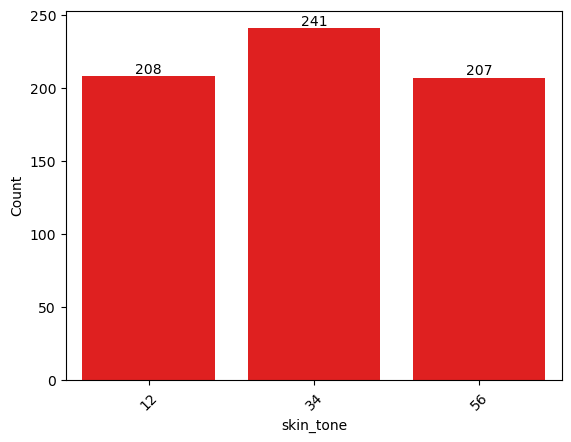

In [14]:
my_plot = sns.countplot(x='skin_tone', data=data, color='r')

for p in my_plot.patches:
    count = int(p.get_height())  
    my_plot.annotate(
        f'{count}',  
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom'  
    )

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel('Count')  
plt.show()


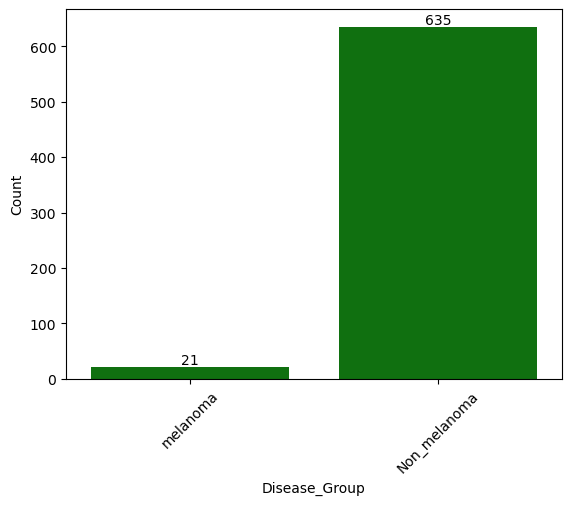

In [15]:
my_plot = sns.countplot(x='Disease_Group', data=data, color='g')

for p in my_plot.patches:
    count = int(p.get_height())  
    my_plot.annotate(
        f'{count}',  
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom'  
    )

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
plt.ylabel('Count')  
plt.show()


In [16]:
data[data["Disease_Group"] == "melanoma"]["skin_tone"].value_counts()


skin_tone
56    7
12    7
34    7
Name: count, dtype: int64

## Now we'll split the data into train set and test set

In [17]:
data.head()


,DDI_ID,DDI_file,skin_tone,malignant,Disease_Group,DDI_path
0,1,000001.png,56,True,melanoma,data\000001.png
1,2,000002.png,56,True,melanoma,data\000002.png
2,3,000003.png,56,True,Non_melanoma,data\000003.png
3,4,000004.png,56,True,Non_melanoma,data\000004.png
4,5,000005.png,12,True,Non_melanoma,data\000005.png


In [ ]:
num_rows_per_skin_tone = 22

skin_tones = data['skin_tone'].unique()
skin_tone_counts = data['skin_tone'].value_counts()

test_df = pd.DataFrame()
train_df = pd.DataFrame()

for skin_tone in skin_tones:
    skin_tone_rows = data[data['skin_tone'] == skin_tone]
    num_rows_to_extract = min(num_rows_per_skin_tone, skin_tone_counts[skin_tone])

    rows_to_extract = skin_tone_rows.sample(n=num_rows_to_extract)

    test_df = pd.concat([test_df, rows_to_extract])

test_df = test_df.sample(frac=1).reset_index(drop=True)

num_rows_to_keep = len(data) - len(test_df)

train_df = data[~data['DDI_ID'].isin(test_df['DDI_ID'].tolist())]

train_df = train_df.sample(frac=1).reset_index(drop=True)



In [20]:
data_malignant_distribution = data.malignant.value_counts(normalize=True) * 100
train_df_malignant_distribution = train_df.malignant.value_counts(normalize=True) * 100
test_df_malignant_distribution = test_df.malignant.value_counts(normalize=True) * 100

print(f"The distribution of the malignant variable in the dataframe:\n{data_malignant_distribution.apply(lambda x: f'{x:.2f}%')}")
print(f"\nThe distribution of the malignant variable in the train data:\n{train_df_malignant_distribution.apply(lambda x: f'{x:.2f}%')}")
print(f"\nThe distribution of the malignant variable in the test_df:\n{test_df_malignant_distribution.apply(lambda x: f'{x:.2f}%')}")


The distribution of the malignant variable in the dataframe:
malignant
False    73.93%
True     26.07%
Name: proportion, dtype: object

The distribution of the malignant variable in the train data:
malignant
False    73.73%
True     26.27%
Name: proportion, dtype: object

The distribution of the malignant variable in the test_df:
malignant
False    75.76%
True     24.24%
Name: proportion, dtype: object


So that confirm that even after splitting the data the distrubition for the malignant is still the same

In [ ]:
print(f"The distribution of the skin tone variable in the dataframe:\n{data.skin_tone.value_counts()}")
print(f"\nThe distribution of the skin tone variable in the train data:\n{train_df.skin_tone.value_counts()}")
print(f"\nThe distribution of the skin tone variable in the test_df:\n{test_df.skin_tone.value_counts()}")


***Now after spliiting the data we should make each image in the train or test folder***

In [23]:
train_path = 'data/train/'
test_path = 'data/test/'
if not os.path.exists(train_path):
    os.makedirs(train_path)
    
if not os.path.exists(test_path):
    os.makedirs(test_path)


In [24]:
train_indexes = train_df.index
for index in tqdm(train_indexes):
    old_path = train_df.DDI_path[index]
    image = cv.imread(old_path)
    name = train_df.DDI_file[index]
    
    new_path = train_path + name
    cv.imwrite(new_path, image)
    train_df['DDI_path'][index] = new_path
    
    os.remove(old_path)
print("Done!")


100%|██████████| 590/590 [00:27<00:00, 21.52it/s]

Done!


In [25]:
test_indexes = test_df.index
for index in tqdm(test_indexes):
    old_path = test_df.DDI_path[index]
    image = cv.imread(old_path)
    name = test_df.DDI_file[index]
    
    new_path = test_path + name
    cv.imwrite(new_path, image)
    test_df['DDI_path'][index] = new_path
    os.remove(old_path)

print("Done!")


100%|██████████| 66/66 [00:03<00:00, 21.16it/s]

Done!


***The images that have not been transferred into the train or test folder are the images that were previously in the test_df, but we decided to delete them to balance our test data.***

In [26]:
folder_path = 'data'

for filename in os.listdir(folder_path):
    if filename.endswith('.png'):
        os.remove(os.path.join(folder_path, filename))
        print(f"Deleted: {filename}")


# Data Augmentation

In our case we can easily se that we have not much data so we decided to make an augmentation for our training data, for this we'll use the albumentations library 

In [27]:
from albumentations import (
    HorizontalFlip, VerticalFlip, Transpose, HueSaturationValue, 
    ElasticTransform, OpticalDistortion, RandomBrightnessContrast, Rotate,
    GridDistortion, CLAHE, GaussNoise, RandomScale
)


def apply_augmentation(image, augmentation_type, **kwargs):
    augmented_image = augmentation_type(p=1, **kwargs)(image=image)['image']
    
    if not isinstance(augmented_image, np.ndarray):
        augmented_image = np.array(augmented_image)
    return augmented_image.astype(np.uint8)


In [ ]:
sharred_augmentation_params = {
    "horizontalFlip": (HorizontalFlip, {}),  
    "randomContrast": (RandomBrightnessContrast, {"brightness_limit": 0, "contrast_limit": 0.4}),  
    "elasticTransform": (ElasticTransform, {}),  
    "randomScaling": (RandomScale, {"scale_limit": 0.2}),  
    "rotate": (Rotate, {"limit": 45})  
}



In [29]:
def data_augmentation(data, augmentation_type_name, train_path):
    augmentation_type, params = sharred_augmentation_params[augmentation_type_name]
    
    train_df_copy = data.copy()
    
    for index, row in train_df_copy.iterrows():
        image = cv.imread(row['DDI_path'])

        augmented_image = apply_augmentation(image, augmentation_type, **params)

        new_name = f"{row['DDI_file'].split('.')[0]}_{augmentation_type_name}.png"
        new_path = train_path + new_name
        cv.imwrite(new_path, augmented_image)
        
        train_df_copy.at[index, 'DDI_path'] = new_path
        train_df_copy.at[index, 'DDI_file'] = new_name

    return train_df_copy


#### Shared augmentation for the two classes

In [30]:
augmented_shared_dfs = {}

for augmentation_type_name in sharred_augmentation_params.keys():
    augmented_shared_dfs[augmentation_type_name] = data_augmentation(train_df, augmentation_type_name, train_path)
    print(f"Shape of {augmentation_type_name}: {augmented_shared_dfs[augmentation_type_name].shape}")

augmented_shared_dfs_values = list(augmented_shared_dfs.values())
train_shared_df_augmented = pd.concat(augmented_shared_dfs_values, axis=0)

print(f"Shape of the augmented DataFrame: {train_shared_df_augmented.shape}")


Shape of horizontalFlip: (590, 6)
Shape of randomContrast: (590, 6)
Shape of elasticTransform: (590, 6)
Shape of randomScaling: (590, 6)
Shape of rotate: (590, 6)
Shape of the augmented DataFrame: (2950, 6)


In [31]:
# Here we'll try to check that there is no issue in the augmented data

for augmentation_type_name, augmented_df in augmented_shared_dfs.items():
    nbr_of_false = 0
    false_file_names = []

    for index, row in augmented_df.iterrows():
        if (row['skin_tone'] != train_df.at[index, 'skin_tone'] or 
            row['malignant'] != train_df.at[index, 'malignant'] or 
            row['Disease_Group'] != train_df.at[index, 'Disease_Group']):
            nbr_of_false += 1
            false_file_names.append(row['DDI_file'])
    
    if nbr_of_false > 0:
        print(f"Issue in {augmentation_type_name} with {nbr_of_false} mismatched files.")
    else:
        print(f"{augmentation_type_name} validation passed.")


horizontalFlip validation passed.
randomContrast validation passed.
elasticTransform validation passed.
randomScaling validation passed.
rotate validation passed.


**Concatenate the train_df with the augmented data that we have create**

In [32]:
train_df = pd.concat([train_df, train_shared_df_augmented], axis=0)
train_df.shape


(3540, 6)

In [33]:
train_df = train_df.sort_values(by='DDI_ID', ascending=True).reset_index()
train_df.head(10)


,index,DDI_ID,DDI_file,skin_tone,malignant,Disease_Group,DDI_path
0,572,1,000001_randomScaling.png,56,True,melanoma,data/train/000001_randomScaling.png
1,572,1,000001_horizontalFlip.png,56,True,melanoma,data/train/000001_horizontalFlip.png
2,572,1,000001_elasticTransform.png,56,True,melanoma,data/train/000001_elasticTransform.png
3,572,1,000001_randomContrast.png,56,True,melanoma,data/train/000001_randomContrast.png
4,572,1,000001_rotate.png,56,True,melanoma,data/train/000001_rotate.png
5,572,1,000001.png,56,True,melanoma,data/train/000001.png
6,66,2,000002_rotate.png,56,True,melanoma,data/train/000002_rotate.png
7,66,2,000002_horizontalFlip.png,56,True,melanoma,data/train/000002_horizontalFlip.png
8,66,2,000002.png,56,True,melanoma,data/train/000002.png
9,66,2,000002_elasticTransform.png,56,True,melanoma,data/train/000002_elasticTransform.png


In [34]:
train_df.drop(['index'], axis=1, inplace = True)
train_df = train_df.reset_index(drop=True)
train_df.head(3)


,DDI_ID,DDI_file,skin_tone,malignant,Disease_Group,DDI_path
0,1,000001_randomScaling.png,56,True,melanoma,data/train/000001_randomScaling.png
1,1,000001_horizontalFlip.png,56,True,melanoma,data/train/000001_horizontalFlip.png
2,1,000001_elasticTransform.png,56,True,melanoma,data/train/000001_elasticTransform.png


In [35]:
train_df.malignant.value_counts(normalize=True) * 100


malignant
False    73.728814
True     26.271186
Name: proportion, dtype: float64

## Encode the data


In [36]:
from sklearn.preprocessing import OneHotEncoder


In [37]:
y_encoded_dummies = pd.get_dummies(train_df['malignant'])
y_encoded_map = train_df['malignant'].map({False: 0, True: 1})
y_encoded = train_df['malignant'].astype(int)
train_df['malignant'] = y_encoded


y_encoded_dummies_test = pd.get_dummies(test_df['malignant'])
y_encoded_map_test = test_df['malignant'].map({False: 0, True: 1})
y_encoded_test = test_df['malignant'].astype(int)
test_df['malignant'] = y_encoded_test


In [38]:
categorical_columns = ['skin_tone', 'Disease_Group']   

train_df_encoded = pd.get_dummies(train_df, columns=categorical_columns)
test_df_encoded = pd.get_dummies(test_df, columns=categorical_columns)

boolean_columns = train_df_encoded.select_dtypes(include=['bool']).columns
train_df_encoded[boolean_columns] = train_df_encoded[boolean_columns].astype(int)
test_df_encoded[boolean_columns] = test_df_encoded[boolean_columns].astype(int)

print(f"Train data column:\n {train_df_encoded.columns}")
print(f"\nTest data column:\n {test_df_encoded.columns}")


Train data column:
 Index(['DDI_ID', 'DDI_file', 'malignant', 'DDI_path', 'skin_tone_12',
       'skin_tone_34', 'skin_tone_56', 'Disease_Group_Non_melanoma',
       'Disease_Group_melanoma'],
      dtype='object')

Test data column:
 Index(['DDI_ID', 'DDI_file', 'malignant', 'DDI_path', 'skin_tone_12',
       'skin_tone_34', 'skin_tone_56', 'Disease_Group_Non_melanoma',
       'Disease_Group_melanoma'],
      dtype='object')


In [39]:
train_df_encoded.head()


,DDI_ID,DDI_file,malignant,DDI_path,skin_tone_12,skin_tone_34,skin_tone_56,Disease_Group_Non_melanoma,Disease_Group_melanoma
0,1,000001_randomScaling.png,1,data/train/000001_randomScaling.png,0,0,1,0,1
1,1,000001_horizontalFlip.png,1,data/train/000001_horizontalFlip.png,0,0,1,0,1
2,1,000001_elasticTransform.png,1,data/train/000001_elasticTransform.png,0,0,1,0,1
3,1,000001_randomContrast.png,1,data/train/000001_randomContrast.png,0,0,1,0,1
4,1,000001_rotate.png,1,data/train/000001_rotate.png,0,0,1,0,1


In [40]:
test_df_encoded.head()


,DDI_ID,DDI_file,malignant,DDI_path,skin_tone_12,skin_tone_34,skin_tone_56,Disease_Group_Non_melanoma,Disease_Group_melanoma
0,300,000300.png,1,data/test/000300.png,1,0,0,1,0
1,40,000040.png,1,data/test/000040.png,1,0,0,1,0
2,422,000422.png,0,data/test/000422.png,1,0,0,1,0
3,289,000289.png,1,data/test/000289.png,1,0,0,1,0
4,258,000258.png,0,data/test/000258.png,1,0,0,1,0


**Check again the distribution for the malignant column after making the augmentation**

In [41]:
train_df_malignant_distribution = train_df_encoded.malignant.value_counts(normalize=True) * 100
test_df_malignant_distribution = test_df_encoded.malignant.value_counts(normalize=True) * 100

print(f"\nThe distribution of the malignant variable in the train data:\n{train_df_malignant_distribution.apply(lambda x: f'{x:.2f}%')}")
print(f"\nThe distribution of the malignant variable in the test_df:\n{test_df_malignant_distribution.apply(lambda x: f'{x:.2f}%')}")



The distribution of the malignant variable in the train data:
malignant
0    73.73%
1    26.27%
Name: proportion, dtype: object

The distribution of the malignant variable in the test_df:
malignant
0    75.76%
1    24.24%
Name: proportion, dtype: object


In [43]:
train_df_encoded.to_csv('data/train_data.csv', index = False)
test_df_encoded.to_csv('data/test_data.csv', index = False)


# Orginze our images

In [44]:
train_path_malignant = 'data/train/malignant/'
train_path_benign = 'data/train/benign/'


test_path_malignant = 'data/test/malignant/'
test_path_benign = 'data/test/benign/'


paths = [train_path_malignant, train_path_benign, test_path_malignant, test_path_benign]

for path in paths:
    os.makedirs(path, exist_ok=True)


In [45]:
def organize_images(data_df, path_malignant, path_benign):
    
    for index, row in tqdm(data_df.iterrows()):
        image = cv.imread(row['DDI_path'])
        target_path = path_malignant if row['malignant'] else path_benign
        new_path = os.path.join(target_path, row['DDI_file'])
        cv.imwrite(new_path, image)
        
        if os.path.exists(row['DDI_path']):
            os.remove(row['DDI_path'])


In [46]:
organize_images(train_df, train_path_malignant, train_path_benign)
organize_images(test_df, test_path_malignant, test_path_benign)


3540it [03:30, 16.84it/s]
66it [00:03, 19.36it/s]
